# Quantum Method of Lines

### by [Francisco Guzman-Cajica](mailto:2002236d@umich.mx) & [Francisco S. Guzman](francisco.s.guzman@umich.mx)

In this notebook, we are going to go through a tour of how to replicate the results of the paper _Variational Quantum Crank-Nicolson and Method of Lines for the Solution of Initial
Value Problems_. A preprint of the paper is available in the [[arxiv:2404.07016](https://arxiv.org/abs/2404.07016)].

The first step is to import some basic python libraries and the ivp supplementary python code.

In [1]:
# Math and graphing tools
import numpy as np
import matplotlib.pyplot as plt
from math import pi

# Supplementary python code
import ivp

## The Advection Equation

The IVP that we are going to solve first is the Advection equation:
$$
\frac{\partial u}{\partial t} = - \frac{\partial u}{\partial x}
$$
To find the numerical solution of the IVP, the first step is to define the number of qubits that are going to be used: n. This will define the number of points in the discrete domain. Another important parameter is the number of frequencies that are going to be used for the ansatz. Lets remember that the Fourier ansatz asumes the unknown function $u(x)$ to be a Fourier series:
$$
u(x) = \sum_{p = -M}^{M} c_p e^{i2\pi p x}
$$
We also have to determine the temporal domain. To do this, the Courant-Friedrich-Levy Factor (better known as CFL) and the number of time steps (in the code known as Nt) must be determined. The CFL is defined as: $\Delta t/\Delta x$.

The last step of the setup is to determine the initial condition of the problem $u_0(x)$. In this example, we will introduce a Gaussian pulse:
$$
u_0(x) = e^{-\frac{(x-x_0)^2}{\sigma^2}}
$$
where $x_0 = 0.5$ and $\sigma = 0.15$. In the code, we these steps would look like this:

In [2]:
n = 3 # Number of qubits
M = 3 # Number of frequencies
N = 2**n # Dimension of the Hilbert space

CFL = 0.5 # Courant-Friedrich-Levi Factor
Nt  = 2* N # Number of time steps

# Initial condition
x0 = 0.5
sigma = 0.15

def u0(x): # x is a 1d numpy array containing the discrete domain
    """
    This function should be written using
    numpy mathematical functions
    """
    return np.exp(-(x-x0)**2/sigma**2)

The next step is to create a _Initial_Value_Problem_ object. This object will require a couple of arguments:
* __equation_name:__ This option can only be one of the strings: 'advection' or 'wave'. There are the two equations that can be handled by the ivp.py supplementary code.
* __NE:__ This is the number of equations that the IVP contains. The advection equation is only 1 but the wave equation contains 3.
* __n:__ Number of qubits
* __M:__ Number of frequencies
* __CFL:__ Courant-Friedrich-Levi Factor
* __Nt:__ Numbe of timesteps
* __initial_functions_array:__ This should be a list containing the initial condition of each of the equations. Since the advection equation only has 1 equation, the array only contains the u0 function.
* __tol:__ This is a real number. It is the tolerance that the optimizer will use to stop the minimization process.
* __shots:__ This is the number of shots that are going to be used for the SEF formalism. It is the number of times each quantum circuit is ran.
* __results_dir:__ It is the directory where you would like the data of your simulations to be saved.
* __graphs_dir:__ It is the directory where you would like the graphs of your simulations to be saved.

The _Initial_Value_Problem_ object has a lot of useful methods that will be useful. For instance, we can plot how the initial condition.


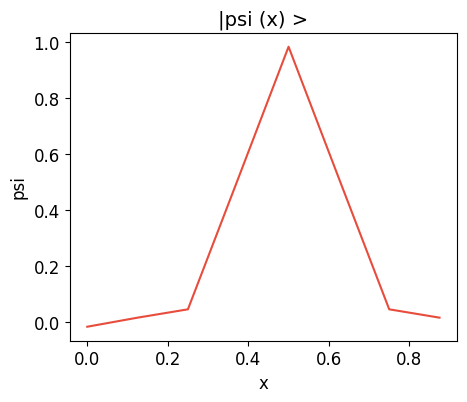

In [3]:
# We construct an instance of the object with some
# choosen parameters
myIVP = ivp.Initial_Value_Problem(equation_name='advection',
    NE=1,n=n,M=M,CFL=CFL,Nt=Nt,
    initial_functions_array=[u0],
    tol=1e-6,
    shots=1000000000,
    results_dir='Advection/Data/',
    graphs_dir='Advection/Graphs/'
)

# This command plots the initial condition
myIVP.plotState(myIVP.FastStateVector(myIVP.l0[0]))

Finally, we can compute the solution with each of the formalisms and plot the solution.

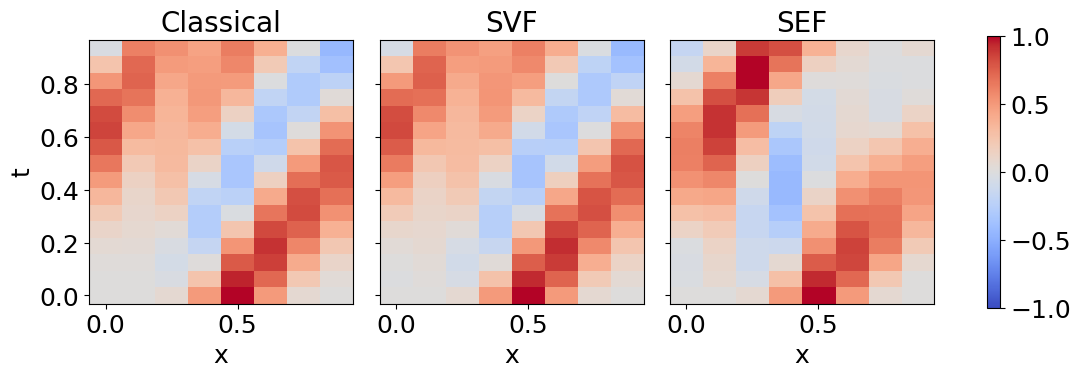

In [4]:
myIVP.evolveClassically()     # formalism 0
myIVP.evolveWithStateVector() # formalism 1
myIVP.evolveWithSampling()    # formalism 2

# We can plot the evolution. The formalisms list contains the index
# of the formalisms you want to plot, since we want to plot
# all of them, we include the 0,1 and 2.
myIVP.plotEvolution(EqNum=0,formalisms=[0,1,2])

## The Wave Equation

We now show an example of how a to solve the wave equation:
$$
\frac{\partial^2 u}{\partial t^2} = \frac{\partial^2 u}{\partial x^2}
$$

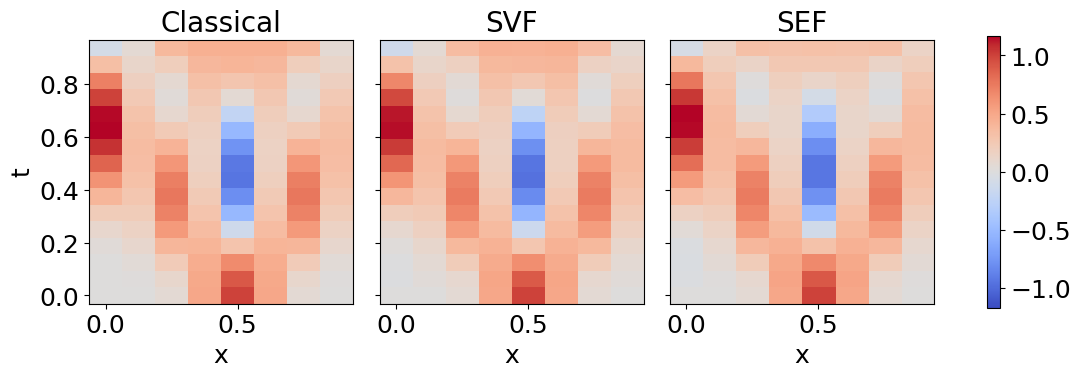

In [5]:
"""
We definde the initial conditions.

These functions should be written using
numpy mathematical functions
"""
x0 = 0.5
sigma = 0.15
# Wave function
def phi(x):
    return np.exp(-(x-x0)**2/sigma**2)
# Partial derivative with respect to t
def P(x):
    return 0.0*x+0.00001
# Partial derivative with respect to x
def Q(x):
    return (-2.0*(x-x0)/sigma**2)*np.exp(-(x-x0)**2/sigma**2)

"""
We create another instance of the object.
In this case I choose the same parameters used for the
advection equation. The results are saved in a different 
directory
"""
myWave = ivp.Initial_Value_Problem(equation_name='wave',
    NE=3,n=3,M=3,CFL=0.5,Nt=16,
    initial_functions_array=[P,Q,phi],
    tol=1e-6,
    shots=1000000000,
    results_dir='Wave/Data/',
    graphs_dir='Wave/Graphs/')

# We execute the evolution
myWave.print_timeSteps = False # You can print the time steps to
                               # track the progress
myWave.evolveClassically()
myWave.evolveWithStateVector()
myWave.evolveWithSampling()

# We plot the wave function, which is the third function
myWave.plotEvolution(EqNum=2,formalisms=[0,1,2])

If you have solved the wave equation with different values of n, you can perform a convergence test.

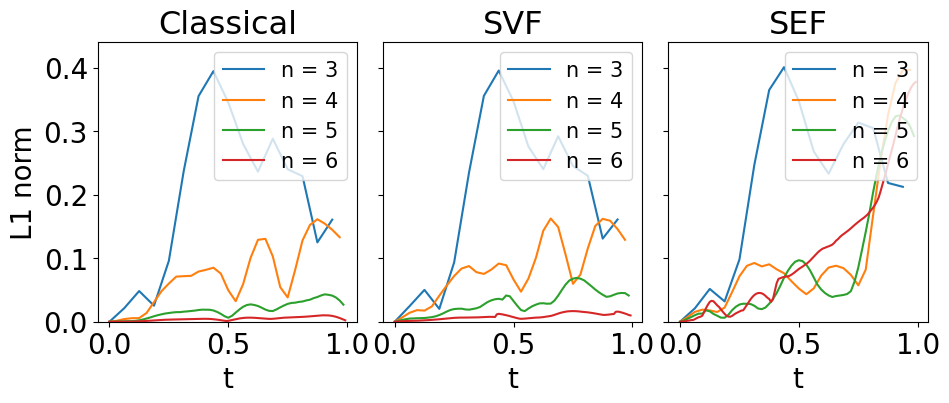

In [6]:
import numpy as np
import ivp

x0 = 0.5
sigma = 0.15
def u_exact(x,t):
    result =  0.5* np.exp(-(x-x0-t)**2/sigma**2) + 0.5*np.exp(-(x-x0+t)**2/sigma**2)\
    + 0.5* np.exp(-(x+x0-t)**2/sigma**2) + 0.5*np.exp(-(x-x0-1.0+t)**2/sigma**2)
    return result

        
ivp.convergeceTest(list_n=[3,4,5,6],list_M=[3,7,7,7],EqNum=2,formalisms=[0,1,2],u_exact=u_exact,results_path='Wave/Data/',path_for_graph='Wave/Graphs/convergenceWave.png')



Here are the versions used to execute the code:

In [7]:
import numpy as np
import matplotlib
import scipy

print("NumPy version:", np.__version__)
print("Matplotlib version:", matplotlib.__version__)
print("SciPy version:", scipy.__version__)

NumPy version: 1.26.4
Matplotlib version: 3.8.3
SciPy version: 1.12.0
